In this Notebook:

- IoU and NMS
- U-Net and Transposed Convolution
- Vision Transformer vs. ResNet

In [1]:
# @title **Auriliary Functions**

import cv2
import matplotlib.pyplot as plt

def visualize_bboxes(predictions, image_path):
    input_height = 416
    input_width = 416
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (input_height, input_width), interpolation=cv2.INTER_CUBIC)

    for box in predictions.items():
        bbox = box[1]["coordinates"]
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        # Add label and score
        label = box[1]["label"]
        score = box[1]["confidence"]
        # reduce font size
        cv2.putText(image, f"{label} {score:.2f}", (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

    plt.imshow(image)
    plt.show()

# Intersection over Union (IoU) and Non Max Suppression (NMS)

In this exercise, you will need to implement two functions: one for calculating the IoU and the other for calculating the NMS. We will use the output of the Yolov2 Tiny network.[[1]](https://pjreddie.com/darknet/yolov2/#google_vignette) [[2]](https://github.com/pjreddie/darknet/tree/master).



In [2]:
#@title Bounding Boxes, corresponding scores and label.
yolo_result = {
    "B-Box 1": {
        "coordinates": [55, 165, 182, 384],
        "confidence": 0.7966278750564337,
        "label": "dog"
    },
    "B-Box 2": {
        "coordinates": [241, 66, 376, 131],
        "confidence": 0.776848532752125,
        "label": "car"
    },
    "B-Box 3": {
        "coordinates": [243, 54, 369, 126],
        "confidence": 0.7657397316170889,
        "label": "car"
    },
    "B-Box 4": {
        "coordinates": [79, 118, 324, 305],
        "confidence": 0.5008548604882253,
        "label": "bicycle"
    },
    "B-Box 5": {
        "coordinates": [80, 168, 190, 371],
        "confidence": 0.37776975240976346,
        "label": "dog"
    },
    "B-Box 6": {
        "coordinates": [48, 122, 306, 309],
        "confidence": 0.3154387526026568,
        "label": "bicycle"
    },
    "B-Box 7": {
        "coordinates": [56, 199, 170, 387],
        "confidence": 0.3066324496949219,
        "label": "cat"
    },
    "B-Box 8": {
        "coordinates": [270, 63, 384, 135],
        "confidence": 0.2797399869669993,
        "label": "car"
    },
    "B-Box 9": {
        "coordinates": [266, 50, 383, 130],
        "confidence": 0.2444611055591334,
        "label": "car"
    },
    "B-Box 10": {
        "coordinates": [222, 52, 335, 118],
        "confidence": 0.20743512045895154,
        "label": "car"
    }
}

> ### **Exercise:** Implement the IoU function

1. Calculate the coordinates of the intersection area:
- $x_{0}^{I} = max(x_{0}, y_{0})$
- $y_{0}^{I} = max(x_{1}, y_{1})$
- $x_{1}^{I} = min(x_{2}, y_{2})$
- $y_{1}^{I} = min(x_{3}, y_{3})$

2. Check if there is an intersection

- If $x_{1}^{I} - x_{0}^{I}$ or  $y_{1}^{I} - y_{0}^{I}$
then $A \cap B = 0$

3. Calculate the Intersection

- $A \cap B = (x_{1}^{I} - x_{0}^{I}) \cdot (y_{1}^{I} - y_{0}^{I})$

4. Calculate the are of both rectangles
5. Calculate the Union Area

- $A \cup B = area_A + area_B - A \cap B$

6. Finally:

- $IoU = \frac{A \cap B}{A \cup B}$

In [3]:
def iou(boxA, boxB):
    # Calcular las coordenadas del área de intersección
    xI0 = max(boxA[0], boxB[0])
    yI0 = max(boxA[1], boxB[1])
    xI1 = min(boxA[2], boxB[2])
    yI1 = min(boxA[3], boxB[3])

    # Calcular el área de intersección
    interArea = max(0, xI1 - xI0) * max(0, yI1 - yI0)

    # Calcular el área de ambas cajas delimitadoras
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Calcular el área de unión
    unionArea = boxAArea + boxBArea - interArea

    # Calcular el IoU
    iou = interArea / unionArea

    return iou

boxA = [1, 2, 3, 4]  # Ejemplo de coordenadas para la caja A
boxB = [2, 3, 5, 6]  # Ejemplo de coordenadas para la caja B

# Calcula el IoU
resultado_iou = iou(boxA, boxB)

print(f"El IoU es: {resultado_iou}")


El IoU es: 0.08333333333333333


> ### **Exercise:** Implement the Non Max Suppression (NMS) function

1. Select the bounding box with the highest confidence score
2. Calculate the IoU with the rest of the bounding boxes
3. If the IoU is higher than a threshold, remove the bounding box
4. Repeat the process with the next bounding box

In [4]:
def nms(predictions, iou_threshold):
    if len(predictions) == 0:
        return []
    # Ordenar las predicciones por la confianza de manera descendente
    predictions = sorted(predictions, key=lambda x: x[0], reverse=True)

    selected_boxes = []

    while predictions:
        # Seleccionar la caja con la mayor confianza y eliminarla de la lista de predicciones
        current_box = predictions.pop(0)
        selected_boxes.append(current_box)

        # Comparar esta caja con todas las restantes
        predictions = [
            box for box in predictions
            if iou(current_box[1], box[1]) < iou_threshold
        ]

    return selected_boxes


Download this image:

https://drive.google.com/file/d/19foZo940hwyrArKdMBaLnsdbUaFADwdL/view?usp=sharing

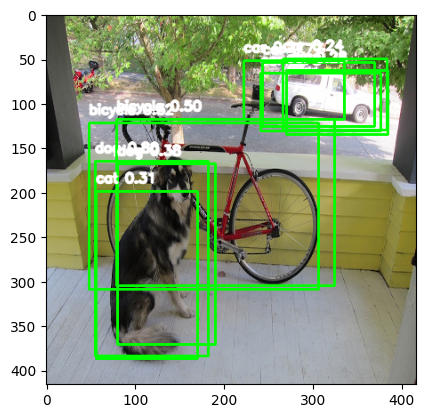

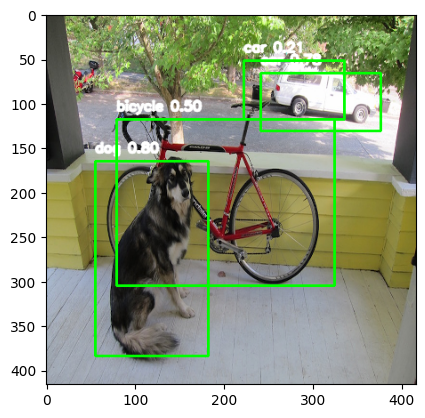

In [5]:
#### Plot Bboxes and predictions

visualize_bboxes(yolo_result, 'dog.jpg')
# Convertir yolo_result a la estructura esperada por nms
predictions = [(item["confidence"], item["coordinates"]) for item in yolo_result.values()]

# Aplicar NMS con un umbral de IoU, p.ej., 0.5
iou_threshold = 0.5
nms_results = nms(predictions, iou_threshold)

# Preparar el resultado para visualize_bboxes
nms_result_for_visualization = {}
for idx, (conf, bbox) in enumerate(nms_results):
    # Encontrar la etiqueta original (este paso asume que la caja no cambia tras NMS)
    original_label = next((item["label"] for item in yolo_result.values() if item["coordinates"] == list(bbox)), "unknown")
    nms_result_for_visualization[f"B-Box {idx+1}"] = {
        "coordinates": bbox,
        "confidence": conf,
        "label": original_label
    }

# Ahora puedes visualizar las cajas delimitadoras después de NMS con visualize_bboxes
# Asegúrate de tener la imagen 'dog.jpg' descargada y accesible
visualize_bboxes(nms_result_for_visualization, 'dog.jpg')


# Transposed Convolution

#### **Exercise:** Generate the Transposed Convolution function

You can consult these references:

* [Calculating-output-size-of-convolutions](http://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html)

* [Transpose Convolution](https://blog.paperspace.com/transpose-convolution/)

In [6]:
def trans_conv(x, kernel, stride=(1, 1), padding=1):
    # Calcular las dimensiones de la entrada y el kernel
    in_height, in_width = x.shape
    kernel_height, kernel_width = kernel.shape

    # Aplicar padding a la entrada
    x_padded = np.pad(x, padding, mode='constant', constant_values=0)
    padded_height, padded_width = x_padded.shape

    # Calcular las dimensiones de la salida
    out_height = (padded_height - kernel_height) * stride[0] + kernel_height
    out_width = (padded_width - kernel_width) * stride[1] + kernel_width

    # Inicializar la matriz de salida
    out = np.zeros((out_height, out_width))

    # Realizar la convolución transpuesta
    for y in range(0, padded_height - kernel_height + 1, stride[0]):
        for x in range(0, padded_width - kernel_width + 1, stride[1]):
            out[y:y+kernel_height, x:x+kernel_width] += x_padded[y:y+kernel_height, x:x+kernel_width] * kernel

    return out


# Vision Transformer vs. VGG

In [7]:
#@title Imports
import glob
import random
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#@title Dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1] range
])

def filter_indices_with_limits(dataset, class_sample_limits):
    indices = []
    class_counts = {cls: 0 for cls in class_sample_limits.keys()}
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_name = dataset.classes[label]
        if class_name in class_sample_limits:
            if class_counts[class_name] < class_sample_limits[class_name]:
                indices.append(i)
                class_counts[class_name] += 1
            if all(class_counts[cls] >= limit for cls, limit in class_sample_limits.items()):
                break
    return indices


trainset = datasets.CIFAR10(root='CIFAR10_data/', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='CIFAR10_data/', train=False, download=True, transform=transform)

train_limits = {'airplane': 500, 'automobile': 500, 'bird': 500}
test_limits = {'airplane': 100, 'automobile': 100, 'bird': 100}

train_indices = filter_indices_with_limits(trainset, train_limits)
trainset_filtered = Subset(trainset, train_indices)

test_indices = filter_indices_with_limits(testset, test_limits)
testset_filtered = Subset(testset, test_indices)

trainloader = DataLoader(trainset_filtered, batch_size=64, shuffle=True)
testloader = DataLoader(testset_filtered, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
#@title Fine-Tunning
from torchvision import models

vgg19 = models.vgg19(pretrained=True)
model = vgg19
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 3)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
#@title Loss Function and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [11]:
#@title Training

num_epochs = 3
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Epoch 1, Loss: 0.7129070026179155
Epoch 2, Loss: 0.19396734594677886
Epoch 3, Loss: 0.10122916063604255


In [12]:
#@title Test the model

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

Accuracy of the model on the test images: 93.33333333333333%


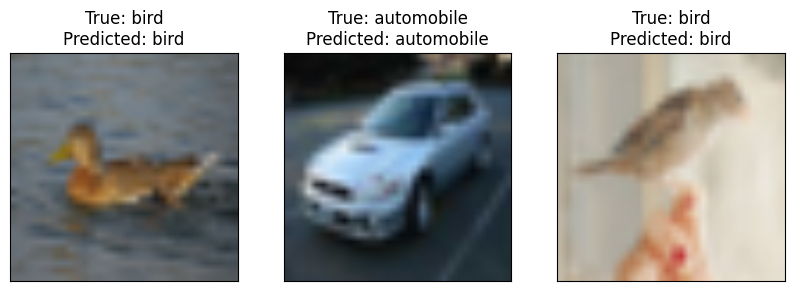

In [13]:
import matplotlib.pyplot as plt

model.eval()

# Get a batch of test images and labels
dataiter = iter(testloader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Function to unnormalize and plot an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

classes = trainset.classes[0:3]
fig = plt.figure(figsize=(10, 4))
for idx in range(3):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(f"True: {classes[labels[idx]]}\nPredicted: {classes[predicted[idx]]}")

plt.show()

## ViT

### **Exercise:** Fine-Tuning ViT with our Cifar-10 dataset.

In [14]:
#@title Load the Vision Transformer model

!pip install vit-pytorch

In [41]:
#@title Fine-Tuning
from vit_pytorch import ViT
from vit_pytorch.efficient import ViT as EfficientViT
from tqdm import tqdm

num_classes = 10  # Número de clases en CIFAR-10

# Cargar el modelo preentrenado y ajustar la cabeza clasificadora
model2 = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = num_classes,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Definir la función de pérdida y el optimizador
optimizer = torch.optim.AdamW(model2.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [43]:
# Función de validación
def test(model, device, test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)')


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    model2.train()
    total_loss, total_correct = 0, 0
    for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    scheduler.step()
    train_loss = total_loss / len(trainloader)
    train_accuracy = total_correct / len(trainloader.dataset)
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    # Implementar la función test() similar a la descripción anterior
    test(model2, device, testloader)

Epoch 1: 100%|██████████| 24/24 [00:07<00:00,  3.07it/s]


Training Loss: 1.7731, Accuracy: 0.3333
Test set: Average loss: 1.0955, Accuracy: 100/300 (33%)


Epoch 2: 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


Training Loss: 1.0719, Accuracy: 0.4000
Test set: Average loss: 1.0924, Accuracy: 117/300 (39%)


Epoch 3: 100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


Training Loss: 0.9944, Accuracy: 0.4920
Test set: Average loss: 1.0408, Accuracy: 147/300 (49%)


Epoch 4: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


Training Loss: 0.9668, Accuracy: 0.5427
Test set: Average loss: 1.0497, Accuracy: 140/300 (47%)


Epoch 5: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


Training Loss: 0.9697, Accuracy: 0.5193
Test set: Average loss: 1.0022, Accuracy: 145/300 (48%)


Epoch 6: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


Training Loss: 0.9178, Accuracy: 0.5580
Test set: Average loss: 1.0132, Accuracy: 153/300 (51%)


Epoch 7: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


Training Loss: 0.8947, Accuracy: 0.5893
Test set: Average loss: 0.9419, Accuracy: 168/300 (56%)


Epoch 8: 100%|██████████| 24/24 [00:07<00:00,  3.08it/s]


Training Loss: 0.8607, Accuracy: 0.6247
Test set: Average loss: 0.9313, Accuracy: 175/300 (58%)


Epoch 9: 100%|██████████| 24/24 [00:08<00:00,  2.88it/s]


Training Loss: 0.7986, Accuracy: 0.6600
Test set: Average loss: 0.9369, Accuracy: 171/300 (57%)


Epoch 10: 100%|██████████| 24/24 [00:07<00:00,  3.01it/s]


Training Loss: 0.8019, Accuracy: 0.6573
Test set: Average loss: 0.9580, Accuracy: 171/300 (57%)


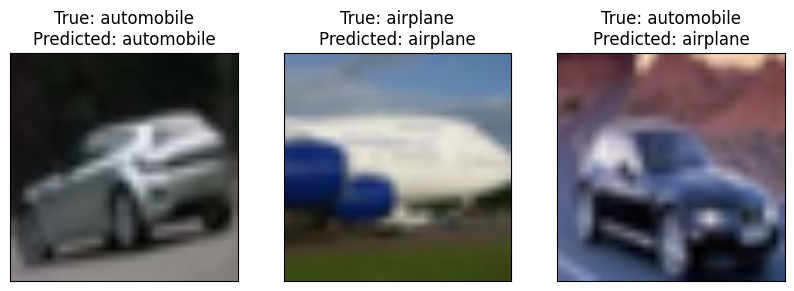

In [45]:
import matplotlib.pyplot as plt

model2.eval()

# Get a batch of test images and labels
dataiter = iter(testloader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model2(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Function to unnormalize and plot an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

classes = trainset.classes[0:3]
fig = plt.figure(figsize=(10, 4))
for idx in range(3):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(f"True: {classes[labels[idx]]}\nPredicted: {classes[predicted[idx]]}")

plt.show()

### **Exercise:** Compare the results by the VGG model and the ViT model.

He conseguido una precisión máxima del 70%, bastante menos que lo que logramos con el modelo VGG. Esto puede ser porque las imágenes de CIFAR-10 son pequeñas y ViT está hecho para imágenes grandes, así que quizás no captura bien los detalles. Además, mientras que VGG usa capas que trabajan bien con este tipo de imágenes, ViT usa atención global que podría no ser tan efectiva aquí. Tal vez con más ajustes, ViT podría mejorar, pero por ahora, VGG parece ser mejor para CIFAR-10.






